<a href="https://colab.research.google.com/github/SongheeJo/aiffelthon/blob/main/jungin/Baseline_ver1_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-io[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 2.5 MB/s 
     |████████████████████████████████| 511.7 MB 3.3 kB/s 
     |████████████████████████████████| 1.6 MB 32.2 MB/s 
     |████████████████████████████████| 438 kB 45.5 MB/s 
     |████████████████████████████████| 5.8 MB 6.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [3]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.4 MB/s 


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import soundfile as sf
import librosa as lb
import os

#butterworth
from scipy.signal import butter, sosfilt, sosfreqz

#frequency masking
import tensorflow_io as tfio

#shift
import nlpaug.augmenter.audio as naa


In [5]:
root = '/content/drive/MyDrive/aiffel/aiffelthon/'
processed = pd.read_csv(root + 'processed.csv') #우리가 계속 쓸 컬럼입니다

In [6]:
sample_file_5 = []
for idx in range(5):
  audio_file_5 = root + 'processed_audio_files_7sec_22050/' + f'107_2b3_Al_mc_AKGC417L_{idx}.wav'
  sample_file_5.append(audio_file_5)

In [7]:
sample_label = [1,0,1,1,0]

In [8]:
df = pd.DataFrame()
df['data'] = sample_file_5
df['label'] = sample_label

In [9]:
from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split(
    df['data'], df['label'], test_size=0.4)

In [10]:
sr = 16000

In [11]:
import nlpaug.augmenter.audio as naa
from random import uniform

def audio_shift(signal, sr):
  luck = np.random.randint(0,2) # 50% 확률 만들기
  if luck == 0:
    aug = naa.ShiftAug(sampling_rate=sr, duration=uniform(1.5,3.5)) #0과 1 사이의 실수
    return aug.augment(signal)
  else:
    return signal

In [12]:
def audio_speed(signal, sr):
  luck = np.random.randint(0,2) # 50% 확률 만들기
  if luck == 0:
    aug = naa.SpeedAug(zone=(0.2, 0.8), coverage=0.5, factor=(0.5, 1), stateless=True) #0과 1 사이의 실수
    return aug.augment(signal)
  else:
    return signal
    
# coverage = 0.5 하면 전체 길이가 늘어나기만 한다

In [13]:
def audio_slicing(signal, max = 7 * sr):
  if len(signal) > max:
    return signal[:max]
  else:
    return signal

In [14]:
!pip install cmapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3959 sha256=7f2d985f86d6cc2268d1a394f74bff309960e5efdce2fbbf37fb7786774bceb4
  Stored in directory: /root/.cache/pip/wheels/49/9a/c8/486d47fd07a9ca1b91602dd040f727313dbeaa059a45d77521
Successfully built cmapy


In [15]:
import cv2
import cmapy

In [16]:
def pre_aug(signal, label, sr=sr):
  audio = audio_shift(signal, sr)
  audio = audio_speed(audio, sr)
  audio = audio_slicing(audio)
  return audio, label


In [17]:
#shift, speed 적용하기
aug_test = []
for idx in range(len(Xtrain)):
  audio_2, _= lb.load(list(Xtrain)[idx], sr = sr)
  audio_2 = pre_aug(audio_2, list(ytrain)[idx])
  aug_test.append(audio_2)

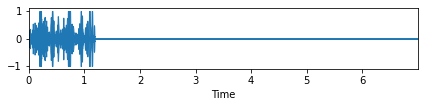

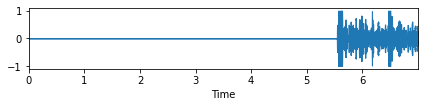

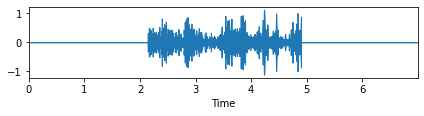

In [18]:
import librosa.display as lbd


plt.figure()

for idx in range(len(aug_test)):
  plt.subplot(3,1,idx+1)
  lbd.waveplot(np.array(aug_test, dtype=object)[idx][0], sr=sr)
  plt.tight_layout()
  plt.show()


mel & clipping

In [19]:
n_mels=128
f_min=100
f_max=16000
nfft=2048
hop= nfft//4

In [49]:
def create_mel_raw(signal, sr=16000, n_mels=128, f_min=100, f_max=16000, nfft=2048, hop=512, resz=1):
    S = lb.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=nfft//4)
    S = lb.power_to_db(S, ref=np.max) # 다음엔 median으로
    S = (S - np.min(S)) / (np.max(S) - np.min(S)) 
    S *= 255
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    height, width, _ = img.shape
    if resz > 0:
        img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR) #bicubic interpolation
    img = cv2.flip(img, 0)
    return img

In [50]:
blank_clipping = []

for idx in range(len(Xtrain)):
  audio_image = cv2.cvtColor(create_mel_raw(np.array(aug_test, dtype=object)[idx][0]), cv2.COLOR_BGR2RGB)

  audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(aug_test, dtype=object)[idx][0]), cv2.COLOR_BGR2GRAY)
  audio_raw_gray[audio_raw_gray < 10] = 0
  for row in range(audio_raw_gray.shape[0]):
    black_percent = len(np.where(audio_raw_gray[row,:]==np.min(audio_raw_gray))[0])/len(audio_raw_gray[row,:])
    if black_percent < 0.80:
      break

  if (row+1)*3 < audio_image.shape[0]:
    audio_image = audio_image[(row+1)*3:, :, :]

  audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
  audio_image, _, __ = cv2.split(audio_image)
  audio_image = cv2.resize(audio_image, (219,128), interpolation=cv2.INTER_LINEAR)
  audio_image = np.array(audio_image, dtype=float)
  #audio_image = (audio_image - np.min(audio_image)) / (np.max(audio_image) - np.min(audio_image))

  blank_clipping.append(audio_image)


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


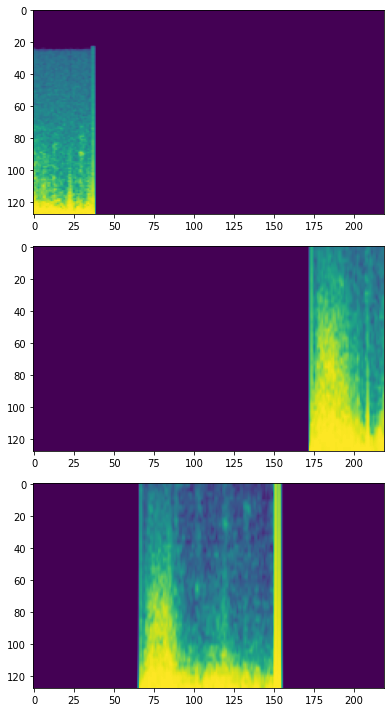

In [51]:
plt.figure(figsize = (10,10))

for idx in range(len(blank_clipping)):
  plt.subplot(3,1,idx+1)
  plt.tight_layout()
  plt.imshow(blank_clipping[idx])

In [66]:
def time_mask(mel):
  luck = np.random.randint(0,2) # 50% 확률 만들기
  if luck == 0:
    return tfio.audio.time_mask(mel, param = 30) #멜 뽑은 넘파이 리스트
  else:
    return tfio.audio.time_mask(mel, param = 1) #텐서로 변환시켜주긴 하니 일단 낮은 확률로 준다

In [68]:
masked = []
for idx in range(len(Xtrain)):
  mask = time_mask(blank_clipping[idx])
  masked.append(mask)

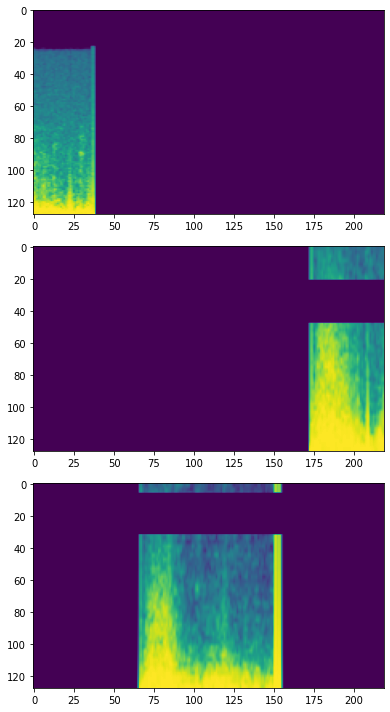

In [69]:
plt.figure(figsize = (10,10))

for idx in range(len(masked)):
  plt.subplot(3,1,idx+1)
  plt.tight_layout()
  plt.imshow(masked[idx])

In [70]:
def process_path(mel, label):
  return mel, label

In [71]:
train_ds = []
for i in range(len(masked)):
  processed_ds = process_path(masked[i], list(ytrain)[i])
  train_ds.append(processed_ds)


In [72]:
train_ds

[(<tf.Tensor: shape=(128, 219), dtype=float64, numpy=
  array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [254., 254., 254., ...,   0.,   0.,   0.],
         [252., 252., 252., ...,   0.,   0.,   0.],
         [251., 252., 252., ...,   0.,   0.,   0.]])>, 1),
 (<tf.Tensor: shape=(128, 219), dtype=float64, numpy=
  array([[  0.,   0.,   0., ...,  88.,  93., 101.],
         [  0.,   0.,   0., ...,  89.,  94., 102.],
         [  0.,   0.,   0., ...,  92.,  98., 104.],
         ...,
         [  0.,   0.,   0., ..., 253., 254., 253.],
         [  0.,   0.,   0., ..., 253., 254., 253.],
         [  0.,   0.,   0., ..., 253., 254., 253.]])>, 1),
 (<tf.Tensor: shape=(128, 219), dtype=float64, numpy=
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.]